In [146]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [77]:
sampled_trips = pd.read_pickle('2023-citibike-tripdata/sampled_trips.pkl')

## Data Prep

In [37]:
# The below approaches did not help the model, so they are excluded

# # calculate distance and bearing
# def haversine_distance(lat1, lng1, lat2, lng2):
#     R = 6371.0
#     lat1_rad = np.radians(lat1)
#     lat2_rad = np.radians(lat2)
#     delta_lat = np.radians(lat2 - lat1)
#     delta_lng = np.radians(lng2 - lng1)
#     a = np.sin(delta_lat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lng / 2.0)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     distance = R * c
#     return distance

# def calculate_initial_bearing(lat1, lng1, lat2, lng2):
#     lat1_rad = np.radians(lat1)
#     lat2_rad = np.radians(lat2)
#     delta_lng = np.radians(lng2 - lng1)
#     x = np.sin(delta_lng) * np.cos(lat2_rad)
#     y = np.cos(lat1_rad) * np.sin(lat2_rad) - np.sin(lat1_rad) * np.cos(lat2_rad) * np.cos(delta_lng)
#     bearing = np.degrees(np.arctan2(x, y))
#     bearing = (bearing + 360) % 360
#     return bearing

In [138]:
# features and target
X = sampled_trips[['start_lat', 'start_lng', 'end_lat', 'end_lng']]
y = sampled_trips['contains_target_street']

X['bearing'] = calculate_initial_bearing(X['start_lat'], X['start_lng'], X['end_lat'], X['end_lng'])

# include grid indices
X['start_grid_lat_idx'] = sampled_trips['start_lat_idx']
X['start_grid_lng_idx'] = sampled_trips['start_lng_idx']
X['end_grid_lat_idx'] = sampled_trips['end_lat_idx']
X['end_grid_lng_idx'] = sampled_trips['end_lng_idx']

# Final feature set
feature_columns = [
    'start_lat', 'end_lat', 
    'end_lng','start_lng',
    #'start_grid_lat_idx',
    #'end_grid_lat_idx', 
]
X = X[feature_columns]

# handle missing values
X = X.dropna()
y = y[X.index]

/var/folders/4p/cnm8c74x2cscn3bny0pr_bvr0000gn/T/ipykernel_21340/1466097923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['bearing'] = calculate_initial_bearing(X['start_lat'], X['start_lng'], X['end_lat'], X['end_lng'])
/var/folders/4p/cnm8c74x2cscn3bny0pr_bvr0000gn/T/ipykernel_21340/1466097923.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['start_grid_lat_idx'] = sampled_trips['start_lat_idx']
/var/folders/4p/cnm8c74x2cscn3bny0pr_bvr0000gn/T/ipykernel_21340/1466097923.py:9: SettingWithCopyW

## Split and sample underrepresented data

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Train model

In [140]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=4,
    class_weight='balanced'
)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=4,
                       random_state=42)

## Eval

Confusion Matrix:
[[16853    71]
 [   43   633]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9975    0.9958    0.9966     16924
        True     0.8991    0.9364    0.9174       676

    accuracy                         0.9935     17600
   macro avg     0.9483    0.9661    0.9570     17600
weighted avg     0.9937    0.9935    0.9936     17600

ROC AUC Score: 0.9991


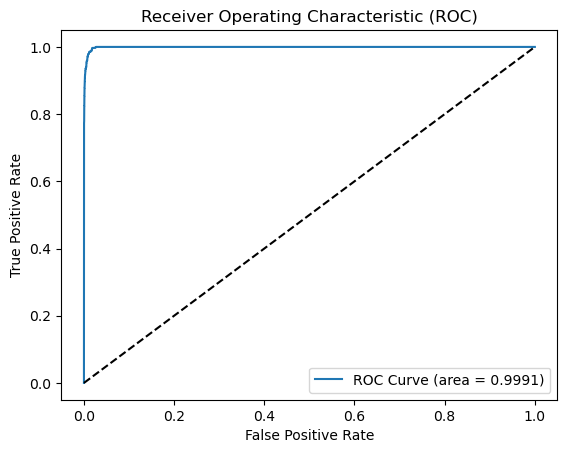

In [141]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


Feature Importances:
     feature  importance
1    end_lat    0.469733
0  start_lat    0.297537
2    end_lng    0.131114
3  start_lng    0.101616


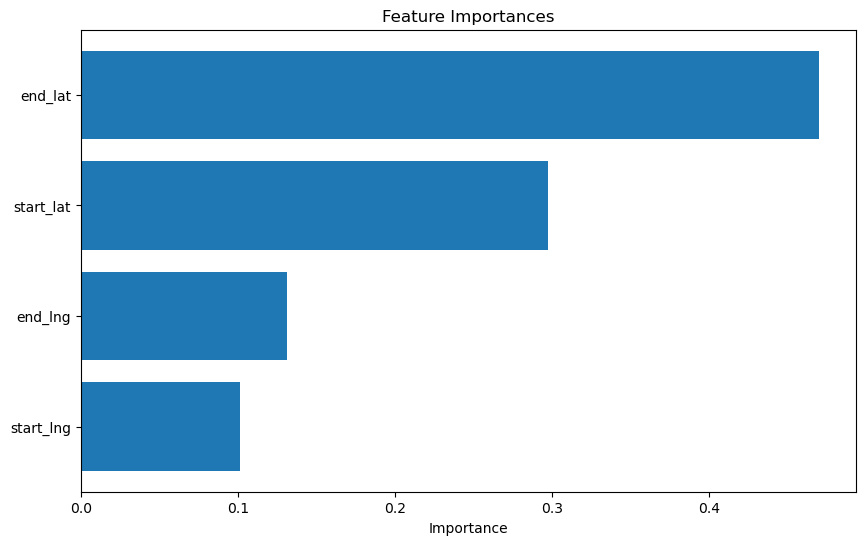

In [143]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [147]:
# Assuming your trained model is stored in 'rf_model'
model_filename = 'rf_model.pkl'

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(rf_model, file)

## Predict

In [151]:
unique_trips = pd.read_pickle('2023-citibike-tripdata/unique_trips.pkl')
df = pd.read_pickle('2023-citibike-tripdata/2023_data.pkl')

In [155]:
X_full = unique_trips[feature_columns]

predictions = rf_model.predict(X_full)
probabilities = rf_model.predict_proba(X_full)[:, 1]

unique_trips['model_prediction'] = predictions
unique_trips['model_proba'] = probabilities

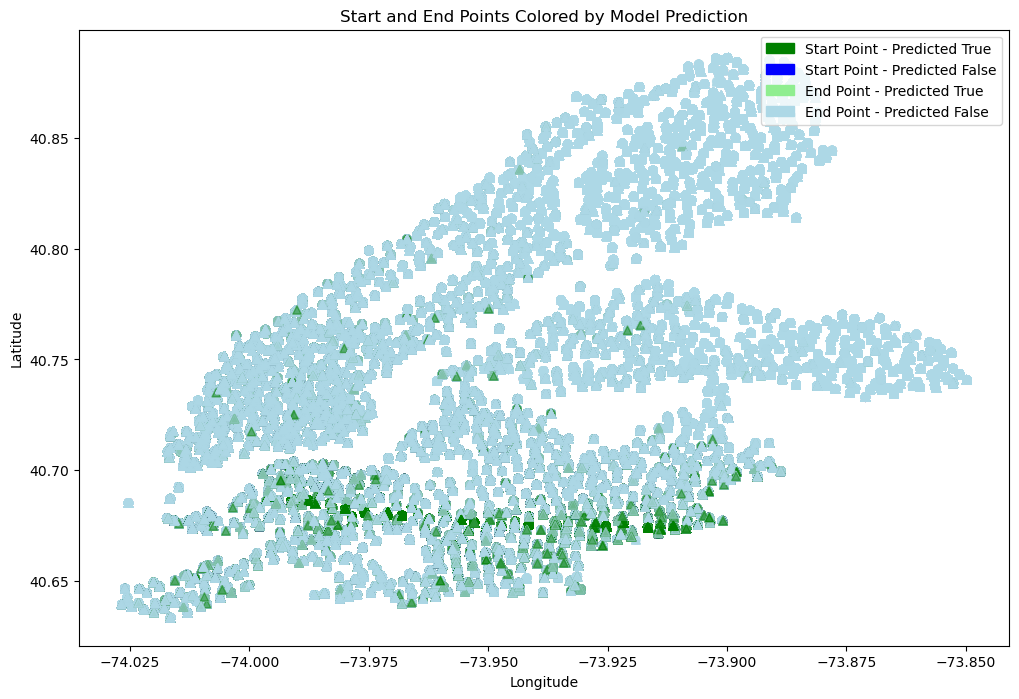

In [167]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot start points
ax.scatter(
    unique_trips['start_lng'],
    unique_trips['start_lat'],
    c=unique_trips['model_prediction'].map({True: 'green', False: 'lightblue'}),
    alpha=0.5,
    label='Start Points',
    marker='o'
)

# Plot end points
ax.scatter(
    unique_trips['end_lng'],
    unique_trips['end_lat'],
    c=unique_trips['model_prediction'].map({True: 'green', False: 'lightblue'}),
    alpha=0.5,
    label='End Points',
    marker='^'
)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Start and End Points Colored by Model Prediction')

# Create custom legend
import matplotlib.patches as mpatches

start_green = mpatches.Patch(color='green', label='Start Point - Predicted True')
start_blue = mpatches.Patch(color='blue', label='Start Point - Predicted False')
end_green = mpatches.Patch(color='lightgreen', label='End Point - Predicted True')
end_blue = mpatches.Patch(color='lightblue', label='End Point - Predicted False')

ax.legend(handles=[start_green, start_blue, end_green, end_blue], loc='upper right')

# Show the plot
plt.show()


In [168]:
unique_trips.head()

,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,model_prediction,model_proba
0,5712.12,5270.07,40.727690,-73.990993,40.715815,-73.994224,False,0.0
1,5743.02,5743.02,40.729840,-73.948390,40.729840,-73.948390,False,0.0
2,5379.10,5379.10,40.717361,-73.958464,40.717452,-73.958509,False,0.0
3,5473.06,5291.05,40.667430,-73.934199,40.715143,-73.944507,False,0.0
4,6257.03,6140.05,40.744876,-73.995299,40.741740,-73.994156,False,0.0


In [171]:
merged = df.merge(unique_trips[['start_station_id','end_station_id','model_prediction']], on=['start_station_id','end_station_id'], how='left')

In [187]:
# per this source CitiBike is about 1/4 of all trips: https://www.nyc.gov/office-of-the-mayor/news/847-23/mayor-adams-dot-commissioner-rodriguez-lyft-expansion-improvements-citi-bike-system

citibike_trips_on_target_streets = (merged['model_prediction']==True).sum()
total_trips_on_target_streets = citibike_trips_on_target_streets*4

In [194]:
print(f'Trips per day: {total_trips_on_target_streets/365:.0f}')

Trips per day: 9041
